In [1]:
# %load_ext kedro.extras.extensions.ipython
# %reload_kedro /home/ubuntu/dmc_2014/dmcfeatures

In [4]:
import pandas as pd
import numpy as np

In [61]:
parameters = catalog.load("parameters")
# del orders
orders_train = catalog.load("orders_train")
orders_test = catalog.load("orders_test")
orders_test_y = catalog.load("orders_test_y")

orders_full = catalog.load("orders_full")

orders_test["returnShipment"] = orders_test_y["returnShipment"]
orders = pd.concat([orders_train, orders_test])
orders["val_set"] = 1
orders.iloc[:len(orders_train), -1] = 0
orders.drop(columns = ["orderItemID"], inplace = True)
orders.replace("?", np.nan, inplace = True)
orders.reset_index(drop=True, inplace=True)
orders.loc[:, "color"] = orders["color"].str.replace("brwon", "brown").str.replace("blau","blue")

2022-03-08 18:12:16,109 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
2022-03-08 18:12:16,110 - kedro.io.data_catalog - INFO - Loading data from `orders_train` (CSVDataSet)...
2022-03-08 18:12:16,731 - kedro.io.data_catalog - INFO - Loading data from `orders_test` (CSVDataSet)...
2022-03-08 18:12:16,788 - kedro.io.data_catalog - INFO - Loading data from `orders_test_y` (CSVDataSet)...
2022-03-08 18:12:16,795 - kedro.io.data_catalog - INFO - Loading data from `orders_full` (PickleDataSet)...


In [32]:
orders_test["basketID"] = orders_test["customerID"].astype(str) + orders_test["deliveryDate"].astype(str)

In [1]:
#  220474 received 131907 returns == PAPER Asdecker
# orders_full["basketID"] = orders_full["customerID"].astype(str) + orders_full["deliveryDate"].astype(str)
# orders_full.drop(orders_full[orders_full["deliveryDate"].isna()].index).groupby("basketID")["returnShipment"].sum()

In [58]:
gru = orders_full.groupby(["customerID", "orderDate"])["deliveryDate"].unique().reset_index()
orders_dropped = orders_full.drop(orders_full[orders_full["deliveryDate"].isna()].index)
less_orders = orders_test.drop(orders_test[orders_test["deliveryDate"]=="?"].index)
59/147 # single item ret_pct

In [40]:
# 13.166 / 22.069
# 13.107 / 21.922 -> when dropping delivery dates=na
(less_orders.groupby("basketID")["returnShipment"].sum()>=1).sum()

13107

In [43]:
# less_orders.groupby("basketID")["returnShipment"].sum()

In [4]:
train = orders[orders["val_set"]==0]
test = orders[orders["val_set"]==1]

In [6]:
# (train["manufacturerID"].value_counts().cumsum()/train.shape[0]).head(50)

## Columns
* nas in deliveryDate (39419), color (143), dateOfBirth (48889) all max ~10%
    * dateOfBirth: impute
    * delivery: impute (+maybe sundaycorrect)
        * check for errors (delivery before order)
    * color: drop
* price: something with sale?
    * watchout: multi-orders (e.g. 2 articles)
    * check occurances of +50% sale: is it less often?
* color: CAT (MAX OHE) oder CATBOOST
* size: CAT
    * problem: different sizes (M vs. 50) per type of clothes
        * maybe adapt all to small letters + keep rest
* manufacturer: catboost (?)
* itemID
    * basket (unten) + catboost
* customer_id*orderDate = Bestnr
    * joint ret_pct
    * basket price
    
* Time columns: orderDate, deliveryDate, creationDate, dateOfBirth
    * orderDate-deliveryDate: time for delivery
        * use days to determine weekends
    * orderDate: no_orders_day
        * use it -> no
    * age -> dateOfBirth-orderDate
    
    
### OHE vs. algorithmic (Catboost)
* OHE vs. own catboosted -> let's see what performs better
* size
    * use rel number of times item got bought
* color
    * same
* possibility: use size+color combination
#### A) all rel_numbers + av combinations B) rel number size + color B) OHE size+ color, rel number mixed C) only OHE D) 

## Time columns >>Finished
Features to create - 1st na the "?"
* bugfixes for dateOfBirth, deliveryDate
    * creation date: bc of system a lot on 2011-02-16 -> upgrade infrastructure etc.
* day features
    * order and day received
    * adjust for sundays
* delivery time [maybe (-1 for sundays)]
* account age = time_creation - day_born
    * maybe binning -> oldest category for acc
* age at order = time order - day born

In [7]:
# correct typo
orders.loc[orders[orders["dateOfBirth"]=="1655-04-19"].index, "dateOfBirth"]= "1955-04-19"
# convert to daytime
time_cols = ["orderDate", "deliveryDate", "creationDate", "dateOfBirth"]
for time_col in time_cols:
    orders.loc[:, time_col] = pd.to_datetime(orders[time_col])
    
# correct senseless dates
    # age: over ~100years or underaged (border year 2000)
weird_age = orders[(orders["dateOfBirth"].dt.year < 1915) & (orders["dateOfBirth"].dt.year >= 2000)].index
orders.loc[weird_age, "dateOfBirth"]= np.nan
    # some bug with delivery_Date in 1990
orders.loc[orders[orders["deliveryDate"].dt.year == 1990].index, "deliveryDate"]= np.nan
    # set same day deliveries to na
same_day_inc = orders[orders["orderDate"]==orders["deliveryDate"]].index
orders.loc[same_day_inc ,"deliveryDate"]= np.nan
    # set day received to median time needed
delivery_median = ((orders["deliveryDate"]-orders["orderDate"]).dt.days).median()
delivery_nas = orders[orders["deliveryDate"].isna()].index
orders.loc[delivery_nas, "deliveryDate"] = orders.loc[
    delivery_nas, "orderDate"] + pd.DateOffset(days = round(delivery_median))
# adjust for sundays (no deliveries)
sundays_inc = orders[orders["deliveryDate"].dt.weekday==6].index
orders.loc[sundays_inc, "deliveryDate"] = orders.loc[
    sundays_inc, "orderDate"] + pd.DateOffset(days = 1)

# create dict for features
feature_cols_time = {}

# create day features
feature_cols_time["DAY_ORDER"] = orders["orderDate"].dt.dayofweek
feature_cols_time["DAY_RECEIVED"] = orders["deliveryDate"].dt.dayofweek

feature_cols_time["TIME_DELIVERY"] = (orders["deliveryDate"]-orders["orderDate"]).dt.days
we_del_ind = feature_cols_time["DAY_ORDER"][
    (feature_cols_time["DAY_ORDER"]>feature_cols_time["DAY_RECEIVED"])&
    (feature_cols_time["DAY_ORDER"] != 6)].index
feature_cols_time["WE_DELIVERY"] = pd.Series(data=0, index = orders.index)
feature_cols_time["WE_DELIVERY"].loc[we_del_ind] = 1 # package not late for those: ppl used to it
feature_cols_time["USER_AGE_ORDER"] = round((orders["orderDate"]-orders["dateOfBirth"]).dt.days/365)

# binary == 1 if account was made on oldest date -> system import
old_sys_inc = orders["creationDate"][orders["creationDate"]==min(orders["creationDate"])].index
feature_cols_time["ACC_OLD_SYS"] = pd.Series(data=0, index = orders.index)
feature_cols_time["ACC_OLD_SYS"].loc[old_sys_inc] = 1
# ~140 freshly made for order
feature_cols_time["ACC_AGE_ORDER"] = (orders["orderDate"]-orders["creationDate"]).dt.days

### Prices and offers
* some prices == 0, lower return pct (<10%)
    * items do usually not always have price = 0
        * 
    * does not seem like mistake etc.
    * most customers just bought the article with price=0

* prices = 0 (1993 transactions)
    * seems like no flaws in data -> keep
* 21 arts (1084 transactions) with items priced always zero
* 20 arts with mixed prices
    * these items have a total of 6653 transactions (909==0)

In [ ]:
# articles not in train df (new)
test[~test["itemID"].isin(train["itemID"])].groupby("itemID")["price"].max()

In [8]:
no_price_arts = orders[orders["price"]==0]["itemID"].unique()
print(orders[orders["price"]==0].shape[0], orders[orders["itemID"].isin(no_price_arts)].shape[0])
len(no_price_arts)

1993 7737


41

In [9]:
orders_0_priced_items_incl = orders[orders["itemID"].isin(no_price_arts)]
nonlinear_arts = orders_0_priced_items_incl[orders_0_priced_items_incl["price"]!=0]["itemID"].unique()
len(nonlinear_arts) # items with 100pct discount

20

In [10]:
only_0_arts = orders_0_priced_items_incl[~orders_0_priced_items_incl["itemID"].isin(nonlinear_arts)]["itemID"].unique()

# arts with price always zero (22) - totaling to 1084 orders
orders[orders["itemID"].isin(only_0_arts)].shape[0]

# need to get imputed afterwards

1084

* numbers of prices + arts + transactions

In [11]:
no_prices = orders_train.groupby("itemID")["price"].nunique()
for price in range(1, 11):
    art_ind = no_prices[no_prices==price].index
    print(price, " prices with no_unique_arts ", orders_train.groupby("itemID")["price"].nunique().value_counts().loc[price]
         , "total transactions: ", orders[orders["itemID"].isin(art_ind)].shape[0])

1  prices with no_unique_arts  1230 total transactions:  153567
2  prices with no_unique_arts  775 total transactions:  103070
3  prices with no_unique_arts  614 total transactions:  132889
4  prices with no_unique_arts  251 total transactions:  77550
5  prices with no_unique_arts  90 total transactions:  31671
6  prices with no_unique_arts  28 total transactions:  15762
7  prices with no_unique_arts  11 total transactions:  8356
8  prices with no_unique_arts  6 total transactions:  5889
9  prices with no_unique_arts  1 total transactions:  1322
10  prices with no_unique_arts  1 total transactions:  1081


In [12]:
multi_price_arts = no_prices.drop(no_prices[no_prices==1].index).index
"""quest_max_p = []
for article in multi_price_arts:
    art_prices = orders[orders["itemID"]==article]["price"]
    if max(art_prices) != art_prices.value_counts().index[0]:
        max_p = max(art_prices)
        occs = art_prices[art_prices==max_p].shape[0]
        print(article,max_p, occs , art_prices.value_counts().iloc[0], art_prices.value_counts().index[0])
        quest_max_p += [article]"""

'quest_max_p = []\nfor article in multi_price_arts:\n    art_prices = orders[orders["itemID"]==article]["price"]\n    if max(art_prices) != art_prices.value_counts().index[0]:\n        max_p = max(art_prices)\n        occs = art_prices[art_prices==max_p].shape[0]\n        print(article,max_p, occs , art_prices.value_counts().iloc[0], art_prices.value_counts().index[0])\n        quest_max_p += [article]'

In [13]:
max_prices = orders.groupby("itemID")["price"].max()
discount = 1- orders.apply(lambda x: x["price"]/max_prices.loc[x["itemID"]], axis = 1)
discount.loc[discount[discount.isna()].index] = 1
# isna for price=0 -> impute 1 as RABATT

/tmp/ipykernel_13543/3333265182.py:2: RuntimeWarning: invalid value encountered in double_scalars
  discount = 1- orders.apply(lambda x: x["price"]/max_prices.loc[x["itemID"]], axis = 1)


In [14]:
# prices differ for article combinations; sometimes even for same (color*itemID*)
day_prices = orders.groupby(["itemID", "orderDate"])["price"].nunique().reset_index()
orders.groupby(["itemID", "orderDate"])["price"].nunique()

itemID  orderDate 
1       2012-04-01    1
        2012-04-02    1
        2012-04-03    1
        2012-04-04    1
        2012-04-05    1
                     ..
3073    2013-04-26    1
3075    2013-04-10    1
3076    2013-04-12    1
3077    2013-04-13    1
3079    2013-04-19    1
Name: price, Length: 171787, dtype: int64

In [15]:
# orders[(orders["itemID"]==1)&(orders["orderDate"]=="2012-06-28")]
# diff_priced = [articles+=  for article in multi_price_arts]
stds_price = orders_train.groupby("itemID")["price"].std()
# (orders_test.groupby("itemID")["price"].std()>0)

<AxesSubplot:>

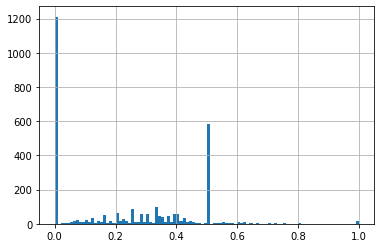

In [16]:
# Rabatt
((orders_train.groupby("itemID")["price"].max() - orders_train.groupby("itemID")["price"].min()) / orders_train.groupby("itemID")["price"].max()).hist(bins = 100)

## CATBOOST
* manufacturer + article number (later)

### Sizes + Colors (clean) + OHE
* clean: size -> upper + lowercase; color -> blau and brwn
* use relative occurances and no_combinations (how often [%] article gets bought per size+color
    * color
    * size
    * size+color
* alternative: OHE
* alternative: cat_size_color_boost --> generate sub-art categories

#### relative occurances

In [17]:
orders.loc[:, "size"] = orders["size"].str.lower()
orders["size"].value_counts()

l       73297
xl      66798
m       61787
xxl     51431
40      37504
        ...  
2932        2
105         2
110         1
4232        1
85          1
Name: size, Length: 115, dtype: int64

In [18]:
train = orders[orders["val_set"]==0]
arts_occ = train.groupby(["itemID"]).size()
rel_sizes = train.groupby(["itemID", "size"]).size().reset_index()
rel_sizes["rel_occ"] = rel_sizes.apply(lambda x: x[0]/arts_occ.loc[x["itemID"]], axis=1)

In [19]:
sizes = orders.groupby(["itemID", "size"]).size().reset_index()
no_sizes = orders.groupby(["itemID"])["size"].nunique()

#### sub-categories (color+size catboosted)
* if possible: use noise (esp for small no of occurances)

In [20]:
train.groupby(["itemID", "color"]).size().mean()

58.438517618469014

In [21]:
train.groupby(["itemID", "size"]).size().mean()

31.164863639308155

In [22]:
# wenige Einträge: Annahme -> eher Farbe oder Größe und nicht beides zusammen hat Einfluss
train.groupby(["itemID", "size", "color"]).size().mean()

11.759144254278729

In [23]:
item_color_cat = orders["itemID"].astype(str)+"_"+orders["color"]
item_size_cat = orders["itemID"].astype(str)+"_"+orders["size"]

## Orders (Basket)
* basket price + n_arts + joint_ret_p

In [24]:
orders["basketID"] = orders["customerID"].astype(str) + orders["orderDate"].astype(str)

n_arts_lookup = orders["basketID"].value_counts()
basket_price_lookup = orders.groupby("basketID")["price"].sum()

orders["basket_price"] = pd.Series(data = basket_price_lookup.loc[orders["basketID"]].values, index = orders.index)
orders["basketNArts"] =  pd.Series(data = n_arts_lookup.loc[orders["basketID"]].values, index = orders.index)

orders.groupby("basketID").size().mean()
# average 3.47 articles in basket
# less than one percent has only one item

3.4740835213708756

In [25]:
# orders with just one article get less often returned
orders[orders["basketNArts"]==1]["returnShipment"].mean()
orders[orders["basketNArts"]>1]["returnShipment"].mean()

0.49861583517443353

In [26]:
orders[orders[["basketID", "itemID"]].duplicated(keep=False)]["returnShipment"].mean()

0.5235652934328342

### plot for paper?

In [27]:
basket_sizes = (orders.groupby("basketID").size().value_counts()*orders.groupby("basketID").size().value_counts().index).sort_index()
# basket_sizes.cumsum().plot()
# plot no_articles per basket size
# basket_sizes.plot()

In [28]:
train = orders[orders["val_set"]==0]
ret_frame = train[train["basketID"].duplicated(keep=False)]
noret_frame = train[~train["basketID"].duplicated(keep=False)]

test = orders[orders["val_set"]==1]
ret_frame = test[test["basketID"].duplicated(keep=False)]
noret_frame = test[~test["basketID"].duplicated(keep=False)]

In [29]:
noret_series = noret_frame.apply(lambda x: x["deliveryDate"].month, axis = 1)
ret_series = ret_frame.apply(lambda x: x["deliveryDate"].month, axis = 1)

In [30]:
examp = {"first": ret_series,
        "second": noret_series}

In [31]:
examp2 = {"first": ret_series,
        "second": noret_series}

In [32]:
ret_col='returnShipment'
ordnr_col='basketID'
artnr_col='itemID'

In [33]:
data = orders
df = data[data["val_set"]==0]
test_df = data[data["val_set"]==1]

# fit
# mean_ret_op = data[parameters['return_type']].mean()
multi_arts = df[df[ordnr_col].duplicated(keep=False)]
multi_arts = multi_arts[[artnr_col, ordnr_col, ret_col]]

ret_arts = multi_arts[multi_arts[ret_col]==1][artnr_col].unique()

In [34]:
# to edit: use dicts; replace artikelnr

def finalize_features(data, parameters: dict):
    ret_col = parameters['ret_col'] # y
    ordnr_col = parameters['ordnr_col'] # indicator
    artnr_col = parameters['artnr_col'] # X (data)
    
    hyperparams = parameters['ret_p_hyperparams']
    min_n_arts = hyperparams["min_joint_baskets"]
    top_fs = hyperparams["top_freq_arts"]
    weights = hyperparams["weights"]
    drop_double_rets = hyperparams["drop_double_returns"]
    
    pd.options.mode.chained_assignment = None
    # feature generation: cut predictions before 
    df = data[data["val_set"]==0]
    test_df = data[data["val_set"]==1]
    
    # fit
    # mean_ret_op = data[parameters['return_type']].mean()
    multi_arts = df[df[ordnr_col].duplicated(keep=False)]
    multi_arts = multi_arts[[artnr_col, ordnr_col, ret_col]]

    ret_arts = multi_arts[multi_arts[ret_col]==1][artnr_col].unique()
    print("Bestellungen in Multi-Art-Warenkörben: ", multi_arts.shape[0], " von ", df.shape[0])
    print("Number of in Multi-Arts-Baskets that got returned ", multi_arts[artnr_col].isin(ret_arts).sum())
    
    ret_arts_frame = multi_arts[multi_arts[artnr_col].isin(ret_arts)]
    lookup_ret_perc_art = ret_arts_frame.groupby(artnr_col)[ret_col].mean().to_dict()

    lookup_tot_ord = multi_arts.groupby(artnr_col).size()
    n_transactions = multi_arts.shape[0]
    lookup_rel_ord = (lookup_tot_ord/n_transactions).to_dict()
    
    # generate empty nested dicts for every combination
    lookup_lift_arts = {key: {} for key in min_n_arts}
    lookup_basket_occ = {key: {} for key in min_n_arts}
    lookup_basket_ret_p = {key: {} for key in min_n_arts}
    lookup_droped_ret_arts = {key: [] for key in min_n_arts}
    for article in ret_arts:
        art_df = multi_arts[multi_arts[artnr_col]==article][[ordnr_col, ret_col]]
        ret_orders = art_df[art_df[ret_col]>=1][ordnr_col]

        basket_df = multi_arts[(multi_arts[ordnr_col].isin(art_df[ordnr_col])) &    # all articles which were ordered with article
                      (multi_arts[artnr_col] != article)]
        if drop_double_rets:   # ignores probability if both articles got returned
            basket_df = basket_df.drop(basket_df[basket_df[ret_col]==1].index)
        else:
            basket_df.loc[:, ret_col] = 0   # set all ret_cols to 0
        ret_incides = basket_df[basket_df[ordnr_col].isin(ret_orders)].index
        basket_df.loc[ret_incides, ret_col] = 1 # set ret_col = 1 if returned
        basket_grouped = basket_df.groupby(artnr_col).size()
        
        # for every min_joint_baseket combination
        for n_arts in min_n_arts:
            arts_basket_occ = basket_grouped[basket_grouped>=n_arts]   # only add arts with sufficient occurances
            if arts_basket_occ.shape[0] > 0:
                lookup_basket_occ[n_arts][article] = arts_basket_occ   # .to_dict() # minimum of co-occurances
                lookup_basket_ret_p[n_arts][article] = basket_df[basket_df[artnr_col].isin(arts_basket_occ.keys())].groupby(
                    artnr_col)[ret_col].mean()  #.to_dict()
                lookup_lift_arts[n_arts][article] = arts_basket_occ.index.to_series().apply(lambda x: (arts_basket_occ.loc[x]/n_transactions)/
                                      (lookup_rel_ord[article]*lookup_rel_ord[x]))
            else:
                lookup_droped_ret_arts[n_arts] += [article]
    
    used_cols = [artnr_col, ordnr_col, ret_col]
    arts_used_ret_p = {}
    arts_ret_p = {}
    for n_arts in min_n_arts:
        for top_f in top_fs:
            for weight in weights:
                colname = "min_"+str(n_arts)+"_top_"+str(top_f)+ "_"+str(weight) + "_"
                data[colname+"_lift"] = np.nan
                data[colname+"_conf"] = np.nan
                # create df for test and train data
                subframe_train = df[df[artnr_col].isin(lookup_basket_ret_p[n_arts].keys()) & # article got returned (+ has at least min_joint_basket occurances)
                        (df[ordnr_col].duplicated(keep=False))][used_cols]    # includes ret_col for train_data to regularize own influence
                subframe_test = test_df[test_df[artnr_col].isin(lookup_basket_ret_p[n_arts].keys()) & # article got returned (+ has at least min_joint_basket occurances)
                        (test_df[ordnr_col].duplicated(keep=False))][[artnr_col, ordnr_col]]
                
                # apply function for lift and confidence to training data
                ret_pcts_conf_train = subframe_train.apply(lambda x: get_ret_perc_train(
                    x[1], x[2], df[used_cols], lookup_basket_ret_p[n_arts][(x[0])], lookup_basket_occ[n_arts][(x[0])],
                    lookup_basket_occ[n_arts][(x[0])], top_f, weight), axis=1, result_type='expand')
                ret_pcts_lift_train = subframe_train.apply(lambda x: get_ret_perc_train(
                    x[1], x[2], df[used_cols], lookup_basket_ret_p[n_arts][(x[0])], lookup_basket_occ[n_arts][(x[0])],
                    lookup_lift_arts[n_arts][(x[0])], top_f, weight), axis=1, result_type='expand')

                # apply function for lift and confidence to test data
                ret_pcts_conf_test = subframe_test.apply(lambda x: get_ret_perc_test(
                    x[1], test_df[used_cols], lookup_basket_ret_p[n_arts][(x[0])], lookup_basket_occ[n_arts][(x[0])],
                    lookup_basket_occ[n_arts][(x[0])], top_f, weight), axis=1, result_type='expand')
                ret_pcts_lift_test = subframe_test.apply(lambda x: get_ret_perc_test(
                    x[1], test_df[used_cols], lookup_basket_ret_p[n_arts][(x[0])], lookup_basket_occ[n_arts][(x[0])],
                    lookup_lift_arts[n_arts][(x[0])], top_f, weight), axis=1, result_type='expand')
                print(ret_pcts_lift_train.iloc[:, 0].head(), ret_pcts_conf_train.iloc[:, 0].head())
                
                arts_used_ret_p[colname+"lift"] = pd.concat([ret_pcts_lift_train.iloc[:, 1],
                                                             ret_pcts_lift_test.iloc[:, 1]])
                arts_used_ret_p[colname+"conf"] = pd.concat([ret_pcts_conf_train.iloc[:, 1],
                                                              ret_pcts_conf_test.iloc[:, 1]])
                
                arts_ret_p[colname+"lift"] = pd.concat([ret_pcts_lift_train.iloc[:, 0],
                                                             ret_pcts_lift_test.iloc[:, 0]])
                arts_ret_p[colname+"conf"] = pd.concat([ret_pcts_conf_train.iloc[:, 0],
                                                              ret_pcts_conf_test.iloc[:, 0]])
        print(colname, "subframe_train:", subframe_train.shape[0], " subframe_test:", subframe_test.shape[0])
                
    return [arts_ret_p, lookup_basket_occ, lookup_basket_ret_p, lookup_ret_perc_art, 
            lookup_tot_ord, lookup_lift_arts, lookup_droped_ret_arts, arts_used_ret_p]

In [35]:
ret_arts_frame = multi_arts[multi_arts[artnr_col].isin(ret_arts)]
lookup_ret_perc_art = ret_arts_frame.groupby(artnr_col)[ret_col].mean().to_dict()

lookup_tot_ord = multi_arts.groupby(artnr_col).size()
n_transactions = multi_arts.shape[0]
lookup_rel_ord = (lookup_tot_ord/n_transactions).to_dict()

In [36]:
rets = train[(train["returnShipment"]==1)&
      ((train["basketNArts"]>1))]["itemID"].value_counts()

In [37]:
multi_arts = train[train[ordnr_col].duplicated(keep=False)]
ret_arts = multi_arts[multi_arts[ret_col]==1][artnr_col].unique()

# basket_grouped = basket_df.groupby(artnr_col).size()

NameError: name 'basket_df' is not defined

In [57]:
parameters = catalog.load("parameters")
# del orders
orders_train = catalog.load("orders_train")
orders_test = catalog.load("orders_test")
orders_test_y = catalog.load("orders_test_y")

2022-02-07 10:41:20,183 - kedro.io.data_catalog - INFO - Loading data from `parameters` (MemoryDataSet)...
2022-02-07 10:41:20,184 - kedro.io.data_catalog - INFO - Loading data from `orders_train` (CSVDataSet)...
2022-02-07 10:41:20,771 - kedro.io.data_catalog - INFO - Loading data from `orders_test` (CSVDataSet)...
2022-02-07 10:41:20,828 - kedro.io.data_catalog - INFO - Loading data from `orders_test_y` (CSVDataSet)...


In [58]:
orders_test["returnShipment"] = orders_test_y["returnShipment"]


In [66]:
combined = pd.concat([orders_train, orders_test])
combined.drop(columns = ["orderItemID"], inplace = True)
combined.replace("?", np.nan, inplace = True)
# combined.drop(combined["color"].isna().index, inplace = True)

combined

,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,2012-04-01,2012-04-03,186,m,denim,25,69.90,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,0
1,2012-04-01,2012-04-03,71,9+,ocher,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
2,2012-04-01,2012-04-03,71,9+,curry,21,69.95,794,Mrs,1965-01-06,Baden-Wuerttemberg,2011-04-25,1
3,2012-04-02,NaN,22,m,green,14,39.90,808,Mrs,1959-11-09,Saxony,2012-01-04,0
4,2012-04-02,1990-12-31,151,39,black,53,29.90,825,Mrs,1964-07-11,Rhineland-Palatinate,2011-02-16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50073,2013-04-29,2013-05-03,2342,M,terracotta,5,69.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,1
50074,2013-04-29,2013-05-03,2505,M,terracotta,5,64.90,91920,Mrs,1962-03-08,Bavaria,2013-04-29,1
50075,2013-04-28,2013-05-02,2470,XL,white,5,79.90,85095,Mrs,1950-02-14,Berlin,2013-03-24,0
50076,2013-04-28,NaN,2452,L,white,5,59.90,91922,Mrs,1969-11-27,Brandenburg,2013-04-28,0


In [ ]:
def get_ret_perc_train(bestnr, ret_ind, data, ret_p_art, occ_arts, sort_arts, top_f, weights):
    # sort arts: use df with lift if lift, else no_occurances
    # function init: pick all articles from basket 
    basket_arts = data[(data.iloc[:, 1] == bestnr) &    # iloc[:,1] = Column ordernr
             (data.iloc[:, 0].isin(ret_p_art.index))].iloc[:, 0]     # iloc[:,0] = Column article
    if len(basket_arts)==0:
        return np.nan, 0
    else: 
        # sorting specified by series in input (from lookup_lift_arts or lookup_basket_occ)
        sorted_arts = sort_arts.loc[basket_arts].sort_values().index.to_series()

        if top_f:
            if type(top_f) == str: # for values like var_5 -> variable 5 or if len(arts)>5 -> take half of the most frq
                n_min = [int(s) for s in top_f if s.isdigit()][0]
                top_f = max(n_min, round(len(sorted_arts)/2))
            sorted_arts = sorted_arts.iloc[-top_f:]

        # adapt for training data (fix ret_p) to prevent overfitting
        ret_p_basket = ret_p_art.loc[sorted_arts]
        occ_basket = occ_arts.loc[sorted_arts]
        no_ret_ind = 1 - ret_ind
        ret_p_basket = (ret_p_basket*occ_basket-ret_ind   # numerator = no returns of article
                                )/(occ_basket-no_ret_ind)  # denominator = no orders of article

        if weights: # if no weigths: only use mean of pcts
            weight = range(1, sorted_arts.shape[0]+1)
            if weights == "sqrt_w":
                weight = np.sqrt(weight)
            ret_pcts = (ret_p_basket*weight).sum()/sum(weight)
        else:
            ret_pcts = ret_p_basket.mean()

        return ret_pcts, occ_basket.sum()

def get_ret_perc_test(bestnr, data, ret_p_art, occ_arts, sort_arts, top_f, weights):
    # function init: pick all articles from basket 
    basket_arts = data[(data.iloc[:, 1] == bestnr) &    # iloc[:,1] = Column ordernr
             (data.iloc[:, 0].isin(ret_p_art.index))].iloc[:, 0]     # iloc[:,0] = Column article
    if len(basket_arts)==0:
        return np.nan, 0
    else:
        # sorting specified by series in input (from lookup_lift_arts or lookup_basket_occ)
        sorted_arts = sort_arts.loc[basket_arts].sort_values().index.to_series()

        if top_f:
            if type(top_f) == str: # for values like var_5 -> variable 5 or if len(arts)>5 -> take half of the most frq
                n_min = [int(s) for s in top_f if s.isdigit()][0]
                top_f = max(n_min, round(len(sorted_arts)/2))
            sorted_arts = sorted_arts.iloc[-top_f:]

        if weights: # if no weigths: only use mean of pcts
            weight = range(1, sorted_arts.shape[0]+1)
            if weights == "sqrt_w": # middle parth for sorting importance-wise
                weight = np.sqrt(weight)
            ret_pcts = (ret_p_art.loc[sorted_arts]*weight).sum()/sum(weight)
        else:
            ret_pcts = ret_p_art.loc[sorted_arts].mean()

        return ret_pcts, occ_arts.loc[sorted_arts].sum()

In [ ]:
hyperparams = parameters['ret_p_hyperparams']
min_n_arts = hyperparams["min_joint_baskets"]
top_fs = hyperparams["top_freq_arts"]
weights = hyperparams["weights"]
drop_double_rets = hyperparams["drop_double_returns"]

for n_arts in min_n_arts:
    for top_f in top_fs:
        for weight in weights:
            print("min_"+str(n_arts)+"_top_"+str(top_f)+ "_"+str(weight) + "_")

In [ ]:
"""    cols_dict = parameters['cols_dict'] 
    data_cols = cols_dict['pass_cat_cols'] + cols_dict['enc_cat_cols'] + cols_dict['cont_cols'] + [parameters['return_type']] + ['BELEGDATUM'] # dates necessary for splits
    data = data[data_cols]
    print(data.shape)"""

In [ ]:
"""def finalize_features(data, parameters: dict):
    ret_col = parameters['ret_col'] # y
    ordnr_col = parameters['ordnr_col'] # indicator
    artnr_col = parameters['artnr_col'] # X (data)
    
    hyperparams = parameters['ret_p_hyperparams']
    min_n_arts = hyperparams["min_joint_baskets"]
    top_fs = hyperparams["top_freq_arts"]
    weights = hyperparams["weights"]
    drop_double_rets = hyperparams["drop_double_returns"]
    
    pd.options.mode.chained_assignment = None
    # feature generation: cut predictions before 
    df = data[data["val_set"]==0]
    test_df = data[data["val_set"]==1]
    
    # fit
    # mean_ret_op = data[parameters['return_type']].mean()
    multi_arts = df[df[ordnr_col].duplicated(keep=False)]
    multi_arts = multi_arts[[artnr_col, ordnr_col, ret_col]]

    ret_arts = multi_arts[multi_arts[ret_col]==1][artnr_col].unique()
    print("Bestellungen in Multi-Art-Warenkörben: ", multi_arts.shape[0], " von ", df.shape[0])
    print("Number of in Multi-Arts-Baskets that got returned ", multi_arts[artnr_col].isin(ret_arts).sum())
    
    ret_arts_frame = multi_arts[multi_arts[artnr_col].isin(ret_arts)]
    lookup_ret_perc_art = ret_arts_frame.groupby(artnr_col)[ret_col].mean().to_dict()

    lookup_tot_ord = multi_arts.groupby(artnr_col).size()
    n_transactions = multi_arts.shape[0]
    lookup_rel_ord = (lookup_tot_ord/n_transactions).to_dict()
    
    # generate empty nested dicts for every combination
    lookup_lift_arts = {key: {} for key in min_n_arts}
    lookup_basket_occ = {key: {} for key in min_n_arts}
    lookup_basket_ret_p = {key: {} for key in min_n_arts}
    lookup_droped_ret_arts = {key: [] for key in min_n_arts}
    for article in ret_arts:
        art_df = multi_arts[multi_arts[artnr_col]==article][[ordnr_col, ret_col]]
        ret_orders = art_df[art_df[ret_col]>=1][ordnr_col]

        basket_df = multi_arts[(multi_arts[ordnr_col].isin(art_df[ordnr_col])) &    # all articles which were ordered with article
                      (multi_arts[artnr_col] != article)]
        if drop_double_rets:   # ignores probability if both articles got returned
            basket_df = basket_df.drop(basket_df[basket_df[ret_col]==1].index)
        else:
            basket_df.loc[:, ret_col] = 0   # set all ret_cols to 0
        ret_incides = basket_df[basket_df[ordnr_col].isin(ret_orders)].index
        basket_df.loc[ret_incides, ret_col] = 1 # set ret_col = 1 if returned
        basket_grouped = basket_df.groupby(artnr_col).size()
        
        # for every min_joint_baseket combination
        for n_arts in min_n_arts:
            arts_basket_occ = basket_grouped[basket_grouped>=n_arts]   # only add arts with sufficient occurances
            if arts_basket_occ.shape[0] > 0:
                lookup_basket_occ[n_arts][article] = arts_basket_occ   # .to_dict() # minimum of co-occurances
                lookup_basket_ret_p[n_arts][article] = basket_df[basket_df[artnr_col].isin(arts_basket_occ.keys())].groupby(
                    artnr_col)[ret_col].mean()  #.to_dict()
                lookup_lift_arts[n_arts][article] = arts_basket_occ.index.to_series().apply(lambda x: (arts_basket_occ.loc[x]/n_transactions)/
                                      (lookup_rel_ord[article]*lookup_rel_ord[x]))
            else:
                lookup_droped_ret_arts[n_arts] += [article]
    return [lookup_lift_arts, lookup_basket_occ, lookup_basket_ret_p, lookup_droped_ret_arts]"""